In [ ]:
from silhouette_upper_bound import upper_bound_samples
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def _get_data(dataset_name: str):
    path = f"data/{dataset_name}/data.csv"

    print(f"==== Running dataset: {dataset_name} ====\n")

    df = pd.read_csv(path)

    print(f"raw df shape = {df.shape}")

    data = df.select_dtypes(include="number")
    print(f"Data shape: {data.shape}")
    return data

In [34]:
def kmeans_optim(data, krange = range(2,30)):

    best_score = 0
    best_scores = None
    best_labels = None
    best_n_clusters = None
    best_min_size = None
    for k in krange:

        kmeans = KMeans(n_clusters=k, random_state=42)

        cluster_labels = kmeans.fit_predict(data) + 1  # 1:indexed 

        cluster_counter = Counter(cluster_labels)

        silh_samples = silhouette_samples(data, cluster_labels)
        silh_score = np.mean(silh_samples)

        if silh_score > best_score:
            best_score = silh_score
            best_scores = silh_samples
            best_labels = cluster_labels
            best_n_clusters = np.max(cluster_labels)
            best_min_size = min(cluster_counter.values())

    return best_labels, best_scores, best_n_clusters, best_min_size

In [3]:
data = _get_data(dataset_name='rna')

==== Running dataset: rna ====

raw df shape = (801, 20532)
Data shape: (801, 20531)


In [ ]:
metric = 'euclidean'
D = pairwise_distances(X=data.to_numpy(), metric=metric)

In [35]:
kmeans_labels, kmeans_scores, n_clusters, min_size = kmeans_optim(data=data)
score = np.mean(kmeans_scores)

In [70]:
kappa = 1
ub_samples = upper_bound_samples(D, kappa = kappa)
ub = np.mean(ub_samples)

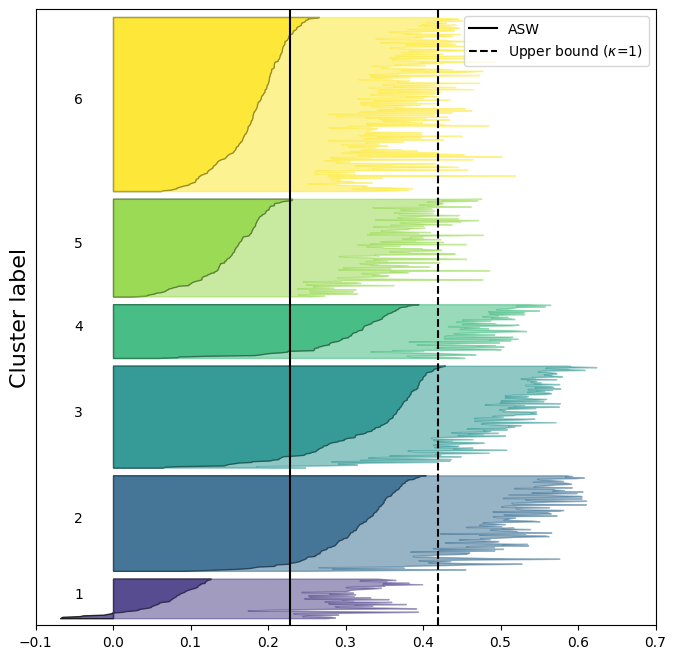

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))

# Silhouette plot setup
ax.set_xlim([-0.1, 0.70])
ax.set_ylim([0, data.shape[0] + (n_clusters + 1) * 10])  # 3 clusters + padding

y_lower = 10
for i in range(1, n_clusters + 1):

    indices = np.where(kmeans_labels == i)[0]
    cluster_silhouettes = kmeans_scores[indices]
    cluster_ub_values = ub_samples[indices]

    # Get sorted order of silhouette values
    sorted_order = np.argsort(cluster_silhouettes)

    sorted_silhouettes = cluster_silhouettes[sorted_order]
    sorted_ub_values = cluster_ub_values[sorted_order]

    size_cluster_i = sorted_silhouettes.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / n_clusters)

    # Cluster Silhouette scores
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        sorted_silhouettes,
        facecolor=color,
        edgecolor='black',
        alpha=0.8,
    )

    # Cluster Silhouette bounds
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        sorted_ub_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.5,
    )

    # Label cluster number
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for spacing between clusters

#ax.set_xlabel("Silhouette widths and upper bounds (shaded)", fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16)
ax.axvline(x=score, color="black", linestyle="-", label="ASW")
ax.axvline(x=ub, color="black", linestyle="--", label=rf"Upper bound ($\kappa$={kappa})")
ax.set_yticks([])  # Clear y-axis labels for clarity
ax.legend(loc='upper right')

plt.savefig(f"silhouette_samples_kappa_{kappa}.pdf")